In [2]:
# Imports
import os
import datetime
import json
from numpy import *
import pandas as pd
import pyopenms as oms
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from tqdm import tqdm
import shutil
import requests
from sklearn.impute import KNNImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline

# Ignore seaborn warning for future deprecation of module part
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# import methods from FIA python script
from FIA import *

In [60]:
def merge_compounds(path_to_tsv:str) -> pd.DataFrame:
	"""
	Joins entries with equal Mass and SumFormula.
	Links CompoundName with: ;
	Links rest with: ,
	"""
	df = pd.read_csv(path_to_tsv, sep="\t")
	
	aggregation_functions = {'CompoundName': lambda x: ";".join(x)}
	groupies = [ df['Mass'], df["SumFormula"], df["Charge"], df["RetentionTime"], df["RetentionTimeRange"], df["IsotopeDistribution"] ]
	df_new = df.groupby( groupies , as_index=False).aggregate(aggregation_functions)


	aggregation_functions = {'Charge': lambda x: x.to_list(),
							 'RetentionTime': lambda x: x.to_list(),
							 'RetentionTimeRange': lambda x: x.to_list(),
							 'IsotopeDistribution': lambda x: x.to_list()}
	groupies = [ df_new['Mass'], df_new["SumFormula"], df_new["CompoundName"]]
	df_new = df_new.groupby( groupies , as_index=False).aggregate(aggregation_functions)

	# Exclude inorganics
	organic_elements = ["H", "C", "N", "P", "I", "Cu", "Mg", "Na", "K", "Zn", "S", "Ca", "Co", "Fe", "O"]
	elements = ['Ac', 'Ag', 'Al', 'Am', 'Ar', 'As', 'At', 'Au', 'B', 'Ba', 'Be', 'Bh', 'Bi', 'Bk', 'Br', 'C', 'Ca', 'Cd', 'Ce', 'Cf', 'Cl', 'Cm', 'Cn', 'Co', 'Cr', 'Cs', 'Cu', 'Db', 'Ds', 'Dy', 'Er', 'Es', 'Eu', 'F', 'Fe', 'Fl', 'Fm', 'Fr', 'Ga', 'Gd', 'Ge', 'H', 'He', 'Hf', 'Hg', 'Ho', 'Hs', 'I', 'In', 'Ir', 'K', 'Kr', 'La', 'Li', 'Lr', 'Lu', 'Lv', 'Mc', 'Md', 'Mg', 'Mn', 'Mo', 'Mt', 'N', 'Na', 'Nb', 'Nd', 'Ne', 'Nh', 'Ni', 'No', 'Np', 'O', 'Og', 'Os', 'P', 'Pa', 'Pb', 'Pd', 'Pm', 'Po', 'Pr', 'Pt', 'Pu', 'Ra', 'Rb', 'Re', 'Rf', 'Rg', 'Rh', 'Rn', 'Ru', 'S', 'Sb', 'Sc', 'Se', 'Sg', 'Si', 'Sm', 'Sn', 'Sr', 'Ta', 'Tb', 'Tc', 'Te', 'Th', 'Ti', 'Tl', 'Tm', 'Ts', 'U', 'V', 'W', 'Xe', 'Y', 'Yb', 'Zn', 'Zr']
	exclude_elements = [e for e in elements if e not in organic_elements]
	for element in exclude_elements:
		df_new = df_new.loc[~df_new["SumFormula"].str.contains(element)]

	return df_new[["CompoundName", "SumFormula", "Mass", "Charge", "RetentionTime", "RetentionTimeRange", "IsotopeDistribution"]].reset_index(drop=True)

In [61]:
df_comp_new = merge_compounds("../databases/compounds.tsv")

In [62]:
df_comp_new

,CompoundName,SumFormula,Mass,Charge,RetentionTime,RetentionTimeRange,IsotopeDistribution
0,protium atom;hydrogen(.),H,1.00783,[0],[1],[0],[0]
1,PMF;H(+),H,1.00794,[1],[1],[0],[0]
2,hydride,H,1.00837,[-1],[1],[0],[0]
3,H2,H2,2.01565,[0],[1],[0],[0]
4,carbon-12(4+),C,11.99781,[4],[1],[0],[0]
...,...,...,...,...,...,...,...
63414,Candida albicans hexasaccharide dendrimer--gly...,C354H569N43O199S2,8670.51678,[0],[1],[0],[0]
63415,(Araf)36(Galf)30-Rha-GlcNAc-P-P-C50,C409H666NO298P2,10421.64827,[-3],[1],[0],[0]
63416,(Araf)63(Galf)30-Rha-GlcNAc-P-P-C50,C484H786NO358P2,12402.28215,[-3],[1],[0],[0]
63417,mycobacterial arabinogalactan containing linea...,C514H834NO382P2,13194.53570,[-3],[1],[0],[0]


In [63]:
df_comp_new.to_csv("../databases/compounds_merged.tsv", sep="\t", index=False)

In [15]:
def define_metabolite_table(path_to_library_file:str, mass_range:list) -> list:
    """
    Read tsv file and create list of FeatureFinderMetaboIdentCompound
    """
    metabo_table = []
    df = pd.read_csv(path_to_library_file, sep="\t")
    df.apply(lambda row: 
        metabo_table.append(
                    oms.FeatureFinderMetaboIdentCompound(
                        row["CompoundName"], row["SumFormula"], row["Mass"],
                        list(map(int, row["Charge"][1:-1].split(", "))), 
                        list(map(float, row["RetentionTime"][1:-1].split(", "))),
                        list(map(float, row["RetentionTimeRange"][1:-1].split(", "))),
                        list(map(float, row["IsotopeDistribution"][1:-1].split(", ")))
                    )
                )
    , axis=1)
    return df, metabo_table

In [16]:
df, mt = define_metabolite_table("../databases/compounds_merged.tsv", [0.0, 10000.0])
len(mt)

2251

In [17]:
df

,CompoundName,SumFormula,Mass,Charge,RetentionTime,RetentionTimeRange,IsotopeDistribution
0,protium atom;hydrogen(.),H,1.00783,"[0, 0]","[1, 1]","[0, 0]","[0, 0]"
1,PMF;H(+),H,1.00794,"[1, 1]","[1, 1]","[0, 0]","[0, 0]"
2,hydride,H,1.00837,[-1],[1],[0],[0]
3,H2,H2,2.01565,[0],[1],[0],[0]
4,carbon-12(4+),C,11.99781,[4],[1],[0],[0]
...,...,...,...,...,...,...,...
2246,circumcircumcoronene,C96H24,1176.18780,[0],[1],[0],[0]
2247,BoBo-1,C41H54I4N6S2,1202.00303,[0],[1],[0],[0]
2248,BoBo-3,C45H58I4N6S2,1254.03433,[0],[1],[0],[0]
2249,ToTo-1,C49H58I4N6S2,1302.03433,[0],[1],[0],[0]


## Loading
Reads in files

In [6]:
experiment_path = "../data/example data/exampleA_ecolistrains/mg1655_P3-A8_neg.mzXML"
experiment = read_experiment(experiment_path)

## Data preparation

### Limit spectrum
Limits range and size by subsampling

In [3]:
# lim_exp = limit_experiment(experiment, 51, 1699, 10**6, deepcopy=True)

In [4]:
# quick_plot(spectrum=lim_exp[0], xlim=[60.975, 61.04], plottype="line")

### Smoothing
Can reduce noise, if peaks are non-Gaussian

In [5]:
# smooth_exp = smooth_spectra(lim_exp, 0.01, deepcopy=True)

In [6]:
# quick_plot(spectrum=smooth_exp[0], xlim=[60.975, 61.04], plottype="line")

$\Rightarrow$ Smoothing not needed, as peaks are sufficently on point and approximately gaussian in distribution

### Centroiding
Reduces data, while retaining peaks

In [7]:
# quick_plot(spectrum=smooth_exp[0], xlim=[60.975, 61.04], plottype="scatter")

In [8]:
# centroid_exp = centroid_experiment(experiment, deepcopy=True)

In [9]:
# oms.MzMLFile().store("../runs/centroided_experiment.MzML", centroid_exp)

In [10]:
# quick_plot(spectrum=centroid_exp[0], xlim=[60.975, 61.04], plottype="scatter")

### Merging
Merging spectra in a specified retention time can increase detection

In [11]:
# quick_plot(spectrum=centroid_exp[0])

In [12]:
# merge_exp = merge_spectra(centroid_exp, block_size=centroid_exp.getNrSpectra(), deepcopy=True)

In [13]:
# quick_plot(spectrum=merge_exp[0])

### Normalization
Useful to compare peaks over spectra

In [14]:
# norm_exp = normalize_spectra(merge_exp, deepcopy=True)

In [15]:
# quick_plot(spectrum=norm_exp[0], plottype="line")

### De-isotoping
Adjusting mass/charge-ratio (m/z) for charge and isotopes

In [16]:
# dynamic_plot(norm_exp)

In [17]:
#deisotop_exp = deisotope_experiment(norm_exp,
#                                    fragment_tolerance=0.1, fragment_unit_ppm=False, min_charge=1, max_charge=1,
#                                    keep_only_deisotoped=True, min_isopeaks=2, max_isopeaks=5, make_single_charged=True, annotate_charge=True,
#                                    annotate_iso_peak_count=True, use_decreasing_model=True, start_intensity_check=False, add_up_intensity=False,
#                                    deepcopy=True)

In [18]:
# dynamic_plot(deisotop_exp)

### Merging positive & negative spectra

In [19]:
# merge positive and negative spectra to amplify signals

## Spectrum Alignment

### Obtaining meabolites
All possible metabolites from BiGG, ChEBI, ModelSEED, MetaNetX

In [20]:
# from urllib.request import urlretrieve
# urlretrieve( "http://bigg.ucsd.edu/static/namespace/bigg_models_metabolites.txt", "../data/databases/BiGG/metabolites.txt")
# urlretrieve( "https://ftp.ebi.ac.uk/pub/databases/chebi/Flat_file_tab_delimited/chemical_data.tsv", "../data/databases/ChEBI/chemical_data.tsv")
# urlretrieve( "https://raw.githubusercontent.com/ModelSEED/ModelSEEDDatabase/master/Biochemistry/compounds.tsv", "../data/databases/SEED/compounds.tsv")
# urlretrieve( "https://www.metanetx.org/cgi-bin/mnxget/mnxref/chem_prop.tsv", "../data/databases/MetaNetX/chem_prop.tsv")

### Condense metabolite info
Parse data to obtain a smaller table with metabolite info

In [21]:
# mnx_df = read_mnx("../databases/MetaNetX/chem_prop.tsv")
# mnx_to_oms(mnx_df).to_csv("../databases/compounds.tsv", sep="\t", index=False)

In [22]:
# compounds = pd.read_csv("../data/databases/compounds.tsv", sep="\t")

In [23]:
# join_df_by(mnx_df.dropna().iloc[0:10000], "mass", "name")

MetaNetX is periodically refreshing their database from BiGG, ChEBI, enviPath, HMDB, KEGG, LipidMaps, MetaCyc, Reactome, SABIO-RK, SwissLipids and ModelSEED. Therefore it should hold the most complete database.

### Defining the theoretical spectrum
Assigning theoretical spectra to the metabolites that can be presen. This is more for peptide detection !

In [24]:
#seq = oms.EmpiricalFormula("H6C2H")
#seq_formula = oms.EmpiricalFormula("H6C2H-1")
#isotopes = seq_formula.getIsotopeDistribution(oms.CoarseIsotopePatternGenerator(6))

In [25]:
#print("[M-H]- weight:", seq_formula.getMonoWeight())

### Assign metabolites to spectrum
Detect peaks at metabolite masses and obtain relative prevalence

In [26]:
# 

## Feature Detection

### Untargeted

In [27]:
filepaths = ["../runs/tr_example/centroided_experiment.MzML"]
fms = [ untargeted_feature_detection(filepath=filepath,
                                     feature_filepath="../runs/tr_example/untargeted.featureXML",
                                     mass_error_ppm=10.0,
                                     noise_threshold_int=10000.0,
                                     remove_single_traces="true") 
        for filepath in filepaths ]
fms_rt = align_retention_times(fms)
fms_a = detect_adducts(fms_rt)

Progress of 'mass trace detection':
-- done [took 0.02 s (CPU), 0.00 s (Wall)] -- 
Progress of 'elution peak detection':
-- done [took 0.07 s (CPU), 0.01 s (Wall)] -- 
Progress of 'assembling mass traces to features':
-- done [took 0.03 s (CPU), 0.00 s (Wall)] -- 
To ensure tracability of results please prefer mzML files as primary MS run.
Filename: '../runs/tr_example/centroided_experiment.MzML'
MassExplainer table size: 312
Generating Masses with threshold: -6.90776 ...
done
2 of 4 valid net charge compomer results did not pass the feature charge constraints
Inferring edges raised edge count from 2 to 2
Found 2 putative edges (of 23) and avg hit-size of 2.5
Using solver 'coinor' ...
Optimal solution found!
 Branch and cut took 0.000978 seconds,  with objective value: 0.12.
ILP score is: 0.12
Agreeing charges: 4/4


In [28]:
# store_feature_maps(fms_a)

### Build Consensus

In [29]:
# cm = consensus_features(fms_a)
# oms.ConsensusXMLFile().store("../runs/FeatureMatrix_.consensusXML", cm)

In [30]:
# df = cm.get_df()
# df

#### Link metabolites to features

In [31]:
# Link it 

### Targeted
Give a list of metabolites with mass, charge and retention time to feature finder

In [32]:
mt = define_metabolite_table("../databases/compounds.tsv", [50.0, 3000.0])
len(mt)

1048469

In [33]:
fm = feature_detection_targeted("../runs/tr_example/centroided_experiment.MzML", mt[0:100], mz_window=5.0, rt_window=200.0, peak_width=3.0)

RT window size calculated as 240 seconds.
Extracting chromatograms...
Detecting chromatographic peaks...
Found 536 feature candidates in total.
92 features left after selection of best candidates.
Model fitting: 1 successes, 44 failures
Imputing model failures with a linear model based on log(rawIntensities). Slope: 1, Intercept: 0.207468


Error: Invalid charge 0 for target '6Z,9Z-Heneicosadien-11-one' - skipping this charge.
Error: Invalid charge 0 for target '4,10-Dimethyltriacontane' - skipping this charge.
Error: Invalid charge 0 for target '9,13-Dimethylheptacosane' - skipping this charge.
Error: Invalid charge 0 for target 'trans-4S,5S-Epoxy-6Z,9Z-nonadecadiene' - skipping this charge.
Error: Invalid charge 0 for target '(Z)-3-Decenyl (E)-2-hexenoate' - skipping this charge.
Error: Invalid charge 0 for target '9Z-Hexadecenyl acetate' - skipping this charge.
Error: Invalid charge 0 for target '2S-Hydroxyoctan-3-one' - skipping this charge.
Error: Invalid charge 0 for target '7,7-Difluoro-8Z-dodecenyl acetate' - skipping this charge.


In [34]:
# fm = targeted_feature_detection("../runs/centroided_experiment.MzML", centroid_exp, "../data/databases/compounds.tsv", mz_window=5.0, rt_window=500.0, peak_width=3.0)
oms.FeatureXMLFile().store("../runs/tr_example/targeted.featureXML", fm)

### Feature annotation by accurate mass

In [35]:
# set path to your mzML files, or leave like this to use the example data
run_dir = "../runs/tr1"
run_dir = os.path.normpath(os.path.join(os.getcwd(), run_dir))

# build_directory(run_dir)

In [36]:
# run_dir = centroid_batch(run_dir, file_ending=".mzML")
run_dir = os.path.normpath(os.path.join(os.getcwd(), os.path.join(run_dir, "centroids")))

In [37]:
feature_maps = untargeted_features_detection(run_dir, ".mzML", 
                                            mass_error_ppm=10.0, noise_threshold_int=1000.0,
                                            width_filtering="fixed", isotope_filtering_model="none", remove_single_traces="true",
                                            mz_scoring_by_elements="false", report_convex_hulls="true")

Progress of 'mass trace detection':
-- done [took 0.01 s (CPU), 0.00 s (Wall)] -- 
Progress of 'elution peak detection':
-- done [took 0.01 s (CPU), 0.00 s (Wall)] -- 
Progress of 'assembling mass traces to features':
-- done [took 0.00 s (CPU), 0.00 s (Wall)] -- 
Progress of 'mass trace detection':
-- done [took 0.02 s (CPU), 0.00 s (Wall)] -- 
Progress of 'elution peak detection':
-- done [took 0.00 s (CPU), 0.00 s (Wall)] -- 
Progress of 'assembling mass traces to features':
-- done [took 0.00 s (CPU), 0.00 s (Wall)] -- 


In [1]:
feature_maps = align_retention_times(feature_maps, 
                                    max_num_peaks_considered=-1,      # -1 -> consider infinite/all peaks
                                    max_mz_difference=10.0,
                                    mz_unit="ppm")

NameError: name 'align_retention_times' is not defined

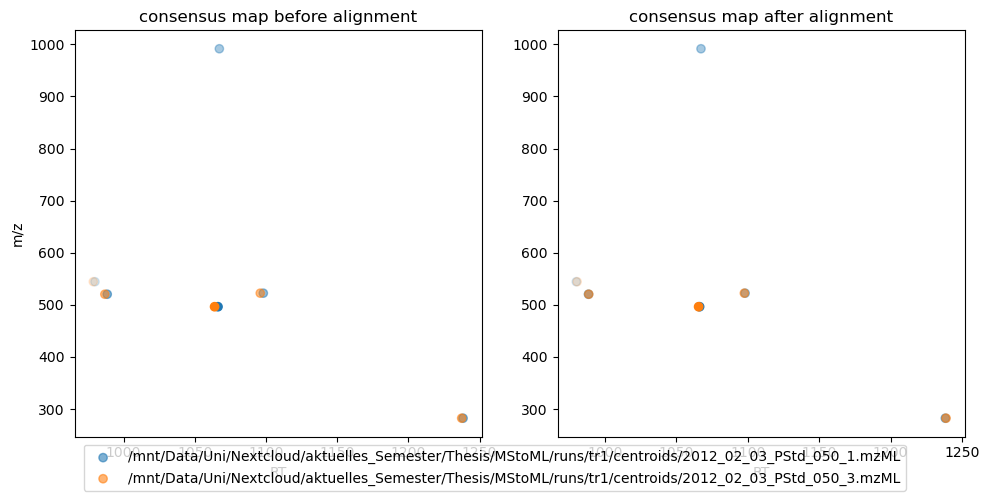

In [39]:
plot_feature_map_rt_alignment(feature_maps)

In [40]:
consensus_map = consensus_features_linking(feature_maps, feature_grouper="KD")

Progress of 'computing RT transformations':
<To ensure tracability of results please prefer mzML files as primary MS run.> occurred 3 times
<Filename: '../runs/tr_example/centroided_experiment.MzML'> occurred 3 times
-- done [took 0.00 s (CPU), 0.00 s (Wall)] -- 
Progress of 'linking features':
-- done [took 0.00 s (CPU), 0.00 s (Wall)] -- 


In [41]:
mass_search_df = accurate_mass_search(consensus_map, "../runs/tr1", "tmp",
 "PositiveAdducts.tsv", "NegativeAdducts.tsv", "HMDBMappingFile.tsv", "HMDB2StructMapping.tsv", ionization_mode="negative")

Read 9635 entries from mapping file!
Read 33 entries from adduct file '../runs/tr1/PositiveAdducts.tsv'.
Read 15 entries from adduct file '../runs/tr1/NegativeAdducts.tsv'.
Hits by adduct: #peaks explained (# matching db entries)'
  'M+Br;1-' : 1 (5)
  'M+Na-2H;1-' : 1 (4)
  'M-H2O-H;1-' : 1 (1)
  'M-H;1-' : 4 (7)



In [42]:
cm_df = consensus_map_to_df(consensus_map)

In [43]:
filtered_cm_df = filter_consensus_map_df(cm_df, max_missing_values=1, min_feature_quality=0.8)
imputed_cm_df = impute_consensus_map_df(filtered_cm_df, n_nearest_neighbours=2)

In [44]:
def consensus_map_df_to_id_df(consensus_map_df:pd.DataFrame, mass_search_df:pd.DataFrame, result_dir:str) -> pd.DataFrame:
    clean_dir(result_dir)
    id_df = consensus_map_df

    id_df["identifications"] = pd.Series(["" for x in range(len(id_df.index))])

    for rt, mz, description in zip(
        mass_search_df["retention_time"],
        mass_search_df["exp_mass_to_charge"],
        mass_search_df["description"],
    ):
        indices = id_df.index[
            isclose(id_df["mz"], float(mz), atol=1e-05)
            & isclose(id_df["RT"], float(rt), atol=1e-05)
        ].tolist()
        for index in indices:
            if description != "null":
                id_df.loc[index, "identifications"] += str(description) + ";"
    id_df["identifications"] = [
        item[:-1] if ";" in item else "" for item in id_df["identifications"]
    ]
    id_df.to_csv(os.path.join(result_dir, "result.tsv"), sep="\t", index=False)
    return id_df

In [46]:
id_df = consensus_map_df_to_id_df(imputed_cm_df, mass_search_df, "../runs/tr1/results")

In [47]:
plot_id_df(id_df)

### Plot

In [ ]:
feature_map = read_feature_map_XML("../runs/targeted.featureXML")

In [ ]:
df = plot_features_3D(feature_map, plottype="line")

In [ ]:
df

,m/z,rt,intensity,labels
0,102.674924,0.000000,8.018,(2E)-geranyl diphosphate
1,102.674924,159.001266,8.733,(2E)-geranyl diphosphate
2,103.009375,0.000000,8.018,(2E)-geranyl diphosphate
3,103.009375,232.764114,8.733,(2E)-geranyl diphosphate
4,159.025499,0.000000,5.161,(3-hydroxy-2-oxindol-3-yl)acetyl-L-aspartate
...,...,...,...,...
1073,330.547834,0.000000,10.162,NADH
1074,330.547834,0.000000,10.876,NADH
1075,331.049511,0.000000,9.447,NADH
1076,331.049511,2743.003174,10.162,NADH


In [ ]:
z_data = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/api_docs/mt_bruno_elevation.csv')
z_data.values.shape

In [ ]:
feature = feature_map[0]